# Research Area Map Plot

In [143]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import mapclassify as mc
from legendgram import legendgram
import palettable.matplotlib as palmpl
import seaborn as sns
import numpy as np
from scipy import stats
#import statsmodels.api as sm

In [8]:
#pip install cartopy

     |████████████████████████████████| 12.1 MB 7.2 MB/s eta 0:00:01    |█████████▋                      | 3.6 MB 7.2 MB/s eta 0:00:02     |██████████████████              | 6.8 MB 7.2 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 219 kB 22.7 MB/s eta 0:00:01
  Created wheel for cartopy: filename=Cartopy-0.19.0.post1-cp37-cp37m-linux_x86_64.whl size=12888838 sha256=d86cf8f75b0739b2446ec505a9c125434c98492b8502cdfd34f6e7e14f94d2f1
  Stored in directory: /home/jovyan/.cache/pip/wheels/98/01/f7/bd10aeb96fe4b518cde5f7c4f5e12c7202f85b7353a5017847
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37264 sha256=9fcfe2f2043017332199576bfdb6e71621b7e2b3900c62c823e8f0c3c0705a5e
  Stored in directory: /home/jovyan/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built cartopy pyshp
Note: you may need to

In [144]:
# Read some MSOA/UK Boundary data for map show
MSOA=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_github/England_basemap/MSOA_Boundary_with_population.gpkg?raw=true')
MSOA = MSOA.to_crs('epsg:27700')
MSOA_all = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/MSOA_Boundaries_December_2011_BSC.geojson?raw=true')
MSOA_all = MSOA_all.to_crs('epsg:27700')
UK = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/UK_outline.gpkg?raw=true')
UK = UK.to_crs('epsg:27700')

<AxesSubplot:>

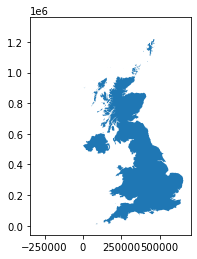

In [88]:
UK.plot()

<AxesSubplot:>

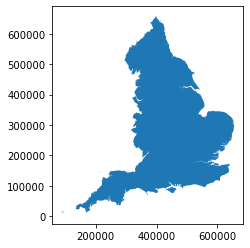

In [14]:
# Get the outline of England MSOA
MSOA['dissolve']=1
MSOA_outline = MSOA.dissolve(by='dissolve')
MSOA_outline.plot()

In [145]:
# function for scale bar
# Source code from: https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot
import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
def _axes_to_lonlat(ax, coords):
    """(lon, lat) from axes coordinates."""
    display = ax.transAxes.transform(coords)
    data = ax.transData.inverted().transform(display)
    lonlat = ccrs.PlateCarree().transform_point(*data, ax.projection)

    return lonlat


def _upper_bound(start, direction, distance, dist_func):
    """A point farther than distance from start, in the given direction.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        direction  Nonzero (2, 1)-shaped array, a direction vector.
        distance:  Positive distance to go past.
        dist_func: A two-argument function which returns distance.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    if distance <= 0:
        raise ValueError(f"Minimum distance is not positive: {distance}")

    if np.linalg.norm(direction) == 0:
        raise ValueError("Direction vector must not be zero.")

    # Exponential search until the distance between start and end is
    # greater than the given limit.
    length = 0.1
    end = start + length * direction

    while dist_func(start, end) < distance:
        length *= 2
        end = start + length * direction

    return end


def _distance_along_line(start, end, distance, dist_func, tol):
    """Point at a distance from start on the segment  from start to end.

    It doesn't matter which coordinate system start is given in, as long
    as dist_func takes points in that coordinate system.

    Args:
        start:     Starting point for the line.
        end:       Outer bound on point's location.
        distance:  Positive distance to travel.
        dist_func: Two-argument function which returns distance.
        tol:       Relative error in distance to allow.

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    initial_distance = dist_func(start, end)
    if initial_distance < distance:
        raise ValueError(f"End is closer to start ({initial_distance}) than "
                         f"given distance ({distance}).")

    if tol <= 0:
        raise ValueError(f"Tolerance is not positive: {tol}")

    # Binary search for a point at the given distance.
    left = start
    right = end

    while not np.isclose(dist_func(start, right), distance, rtol=tol):
        midpoint = (left + right) / 2

        # If midpoint is too close, search in second half.
        if dist_func(start, midpoint) < distance:
            left = midpoint
        # Otherwise the midpoint is too far, so search in first half.
        else:
            right = midpoint

    return right


def _point_along_line(ax, start, distance, angle=0, tol=0.01):
    """Point at a given distance from start at a given angle.

    Args:
        ax:       CartoPy axes.
        start:    Starting point for the line in axes coordinates.
        distance: Positive physical distance to travel.
        angle:    Anti-clockwise angle for the bar, in radians. Default: 0
        tol:      Relative error in distance to allow. Default: 0.01

    Returns:
        Coordinates of a point (a (2, 1)-shaped NumPy array).
    """
    # Direction vector of the line in axes coordinates.
    direction = np.array([np.cos(angle), np.sin(angle)])

    geodesic = cgeo.Geodesic()

    # Physical distance between points.
    def dist_func(a_axes, b_axes):
        a_phys = _axes_to_lonlat(ax, a_axes)
        b_phys = _axes_to_lonlat(ax, b_axes)

        # Geodesic().inverse returns a NumPy MemoryView like [[distance,
        # start azimuth, end azimuth]].
        return geodesic.inverse(a_phys, b_phys).base[0, 0]

    end = _upper_bound(start, direction, distance, dist_func)

    return _distance_along_line(start, end, distance, dist_func, tol)


def scale_bar(ax, location, length, metres_per_unit=1000, unit_name='km',
              tol=0.01, angle=0, color='black', linewidth=3, text_offset=0.005,
              ha='center', va='bottom', plot_kwargs=None, text_kwargs=None,
              **kwargs):
    """Add a scale bar to CartoPy axes.

    For angles between 0 and 90 the text and line may be plotted at
    slightly different angles for unknown reasons. To work around this,
    override the 'rotation' keyword argument with text_kwargs.

    Args:
        ax:              CartoPy axes.
        location:        Position of left-side of bar in axes coordinates.
        length:          Geodesic length of the scale bar.
        metres_per_unit: Number of metres in the given unit. Default: 1000
        unit_name:       Name of the given unit. Default: 'km'
        tol:             Allowed relative error in length of bar. Default: 0.01
        angle:           Anti-clockwise rotation of the bar.
        color:           Color of the bar and text. Default: 'black'
        linewidth:       Same argument as for plot.
        text_offset:     Perpendicular offset for text in axes coordinates.
                         Default: 0.005
        ha:              Horizontal alignment. Default: 'center'
        va:              Vertical alignment. Default: 'bottom'
        **plot_kwargs:   Keyword arguments for plot, overridden by **kwargs.
        **text_kwargs:   Keyword arguments for text, overridden by **kwargs.
        **kwargs:        Keyword arguments for both plot and text.
    """
    # Setup kwargs, update plot_kwargs and text_kwargs.
    if plot_kwargs is None:
        plot_kwargs = {}
    if text_kwargs is None:
        text_kwargs = {}

    plot_kwargs = {'linewidth': linewidth, 'color': color, **plot_kwargs,
                   **kwargs}
    text_kwargs = {'ha': ha, 'va': va, 'rotation': angle, 'color': color,
                   **text_kwargs, **kwargs}

    # Convert all units and types.
    location = np.asarray(location)  # For vector addition.
    length_metres = length * metres_per_unit
    angle_rad = angle * np.pi / 180

    # End-point of bar.
    end = _point_along_line(ax, location, length_metres, angle=angle_rad,
                            tol=tol)

    # Coordinates are currently in axes coordinates, so use transAxes to
    # put into data coordinates. *zip(a, b) produces a list of x-coords,
    # then a list of y-coords.
    ax.plot(*zip(location, end), transform=ax.transAxes, **plot_kwargs)

    # Push text away from bar in the perpendicular direction.
    midpoint = (location + end) / 2
    offset = text_offset * np.array([-np.sin(angle_rad), np.cos(angle_rad)])
    text_location = midpoint + offset

    # 'rotation' keyword argument is in text_kwargs.
    ax.text(*text_location, f"{length} {unit_name}", rotation_mode='anchor',
            transform=ax.transAxes, **text_kwargs)

In [83]:
def map_plot():
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    
    UK.plot(ax=ax, edgecolor=(0.5, 0.5, 0.5,1),facecolor='none', linewidth=0.5)
    ax.axis('off') 
    
    MSOA_all.plot(edgecolor=(0.5, 0.5, 0.5,1), facecolor='none', linewidth=0.1,ax=ax)
    
    MSOA_outline.plot(edgecolor=(0.8, 0, 0,0.8), facecolor=(0.5, 0.5, 0.5,0.05), linewidth=1, ax=ax)
    
    #north arrow
    ax.text(x=520000, y=835000, s='N', fontsize=30)
    ax.arrow(545000, 760000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)


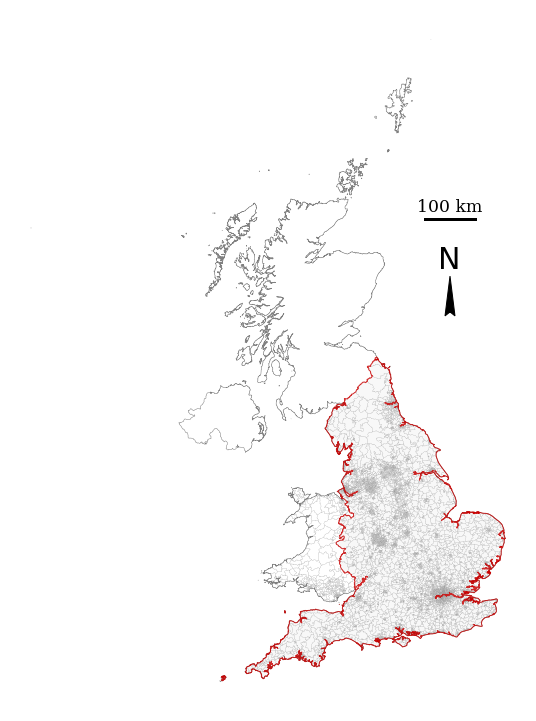

In [85]:
map_plot()
plt.savefig('figure/research_area_map', dpi=600)

# Plot the 9 regions of England

<AxesSubplot:>

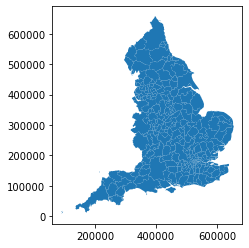

In [146]:
LAD=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/LAD_boundaries.gpkg?raw=true')
LAD = LAD.to_crs('epsg:27700')
LAD.plot()

<AxesSubplot:>

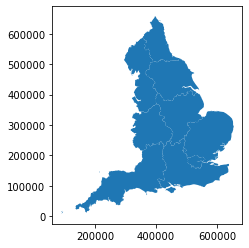

In [147]:
England_9_region = gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/England_9_region.gpkg?raw=true')
England_9_region = England_9_region.to_crs('epsg:27700')
England_9_region.plot()

In [148]:
# Get the center of each region for labeling
England_9_region['coords'] = England_9_region['geometry'].apply(lambda x: x.representative_point().coords[:])
England_9_region['coords'] = [coords[0] for coords in England_9_region['coords']]

In [149]:
England_9_region[['RGN20NM','coords']]

,RGN20NM,coords
0,London,"(520983.74189015536, 178452.19789999974)"
1,North East,"(395433.99780361116, 582131.8425000008)"
2,North West,"(355550.6655405491, 462669.1000500007)"
3,West Midlands,"(386750.9246520191, 292030.6514500004)"
4,Yorkshire and The Humber,"(455231.4153668779, 448323.94800000003)"
5,South West,"(333613.56043704867, 128353.94989999977)"
6,East of England,"(570200.403002183, 261563.25265000004)"
7,South East,"(469874.1223810874, 173071.80000000028)"
8,East Midlands,"(488271.64746866026, 322925.10300000064)"


In [150]:
def map_plot():
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator()) 
    
    England_9_region.plot(edgecolor=(0.8, 0, 0,1), column='RGN20NM', alpha = 0.95,linewidth=1, ax=ax)
    England_9_region['coords'] = England_9_region['geometry'].apply(lambda x: x.representative_point().coords[:])
    England_9_region['coords'] = [coords[0] for coords in England_9_region['coords']]
    
    # annotate
    plt.annotate(text='London', xy=(530984, 180452),verticalalignment='center',horizontalalignment='center',size=16)
    plt.annotate(text='North East', xy=(395434, 582132),verticalalignment='center',horizontalalignment='center',size=16)
    plt.annotate(text='North West', xy=(355551, 462669),verticalalignment='center',horizontalalignment='center',size=16)
    plt.annotate(text='West Midlands', xy=(386751, 292031),verticalalignment='center',horizontalalignment='center',size=16)
    plt.annotate(text='Yorkshire and The Humber', xy=(455231, 448324),verticalalignment='center',horizontalalignment='center',size=16)
    plt.annotate(text='South West', xy=(333614, 128354),verticalalignment='center',horizontalalignment='center',size=16)
    plt.annotate(text='East of England', xy=(570200, 261563),verticalalignment='center',horizontalalignment='center',size=16)
    plt.annotate(text='South East', xy=(489874, 153072),verticalalignment='center',horizontalalignment='center',size=16)
    plt.annotate(text='East Midlands', xy=(488272, 332925),verticalalignment='center',horizontalalignment='center',size=16)
    LAD.plot(ax=ax, edgecolor=(1,1, 1,1),facecolor='none', linewidth=0.5)
    ax.axis('off')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(191000, 525000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.13, 0.6), 100,text_kwargs = text_kwargs)


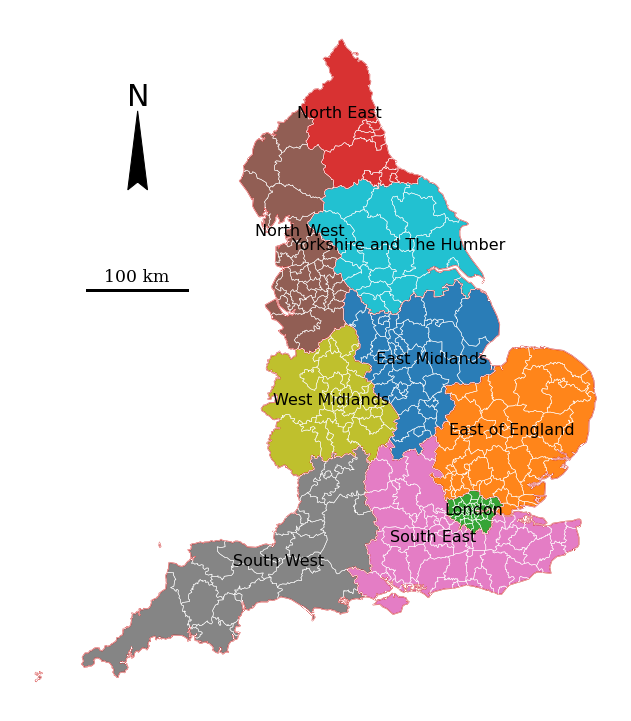

In [151]:
map_plot()
plt.savefig('figure/England_9_region', dpi=600,bbox_inches='tight')

# Plot the vaccination site density map by LAD and find out the areas with highest density 

In [78]:
LAD=gpd.read_file('https://github.com/LingruFeng/dissertation/blob/main/data_raw/LAD_boundaries.gpkg?raw=true')
LAD = LAD.to_crs('epsg:27700')

<AxesSubplot:>

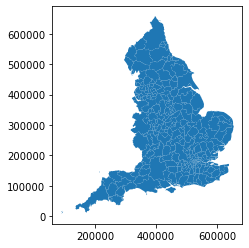

In [79]:
LAD.plot()

In [8]:
LAD

,OBJECTID,LAD20CD,LAD20NM,Shape__Are,popden_sq_,pop,over17_24,over16_64,up65,NUMPOINTS,site_density,geometry
0,1,E06000001,Hartlepool,9.602987e+07,999,95934,8259,57470,18198,1,0.010413,"MULTIPOLYGON (((448906.042 536703.720, 448926...."
1,2,E06000002,Middlesbrough,5.523139e+07,2616,144485,16257,88157,23098,5,0.090528,"MULTIPOLYGON (((451894.389 521145.406, 453997...."
2,3,E06000003,Redcar and Cleveland,2.483428e+08,560,139072,11264,81340,31034,1,0.004027,"MULTIPOLYGON (((478227.056 518780.442, 477689...."
3,4,E06000004,Stockton-on-Tees,2.052314e+08,963,197638,15902,121485,36423,3,0.014618,"MULTIPOLYGON (((452185.294 526288.478, 451741...."
4,5,E06000005,Darlington,1.988128e+08,541,107558,8510,64691,21937,2,0.010060,"MULTIPOLYGON (((436388.002 522354.197, 437351...."
...,...,...,...,...,...,...,...,...,...,...,...,...
309,310,E09000029,Sutton,4.449089e+07,4706,209374,15669,130824,31622,4,0.089906,"MULTIPOLYGON (((529904.494 167407.581, 531249...."
310,311,E09000030,Tower Hamlets,1.952019e+07,16427,320658,38884,238329,20859,39,1.997931,"MULTIPOLYGON (((539050.635 180282.814, 539010...."
311,312,E09000031,Waltham Forest,3.928052e+07,7137,280345,23828,186221,29980,18,0.458242,"MULTIPOLYGON (((540036.303 194159.702, 539157...."
312,313,E09000032,Wandsworth,3.506771e+07,9624,337492,29263,238548,31626,32,0.912521,"MULTIPOLYGON (((529404.296 170556.840, 526498...."


In [16]:
print(u'Site number per km\u00B2')

Site number per km²


In [5]:
def LAD_plot(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    
    LAD.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('England Household percentage with at least one car by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title(u'Site number per km\u00B2')
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)

    q = mc.NaturalBreaks(LAD[column], k=7)
    legendgram(fig, ax, 
                LAD[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

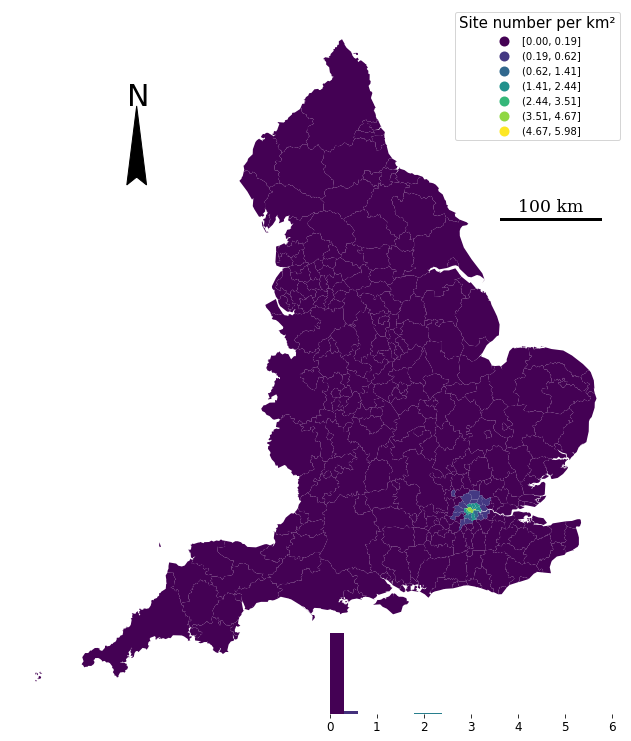

In [6]:
LAD_plot('site_density')

# Find the top 10 LADs have highest vaccination site density/number (London included)

In [28]:
site_number_most=LAD.sort_values(axis = 0,ascending = False,by = 'NUMPOINTS').head(10).reset_index()
site_number_most.drop(columns='index', axis=1,inplace=True)
site_number_most[['LAD20NM','NUMPOINTS','site_density']]

,LAD20NM,NUMPOINTS,site_density
0,Westminster,107,4.673139
1,Lambeth,60,2.207732
2,Camden,48,2.256760
3,Southwark,42,1.407611
4,Kensington and Chelsea,40,3.512525
5,Tower Hamlets,39,1.997931
6,Islington,37,2.442719
7,Hackney,36,1.815162
8,Wandsworth,32,0.912521
9,Hammersmith and Fulham,32,1.845994


In [67]:
site_density_most=LAD.sort_values(axis = 0,ascending = False,by = 'site_density').head(10).reset_index()
site_density_most.drop(columns='index', axis=1,inplace=True)
site_density_most[['LAD20NM','NUMPOINTS','site_density']]

,LAD20NM,NUMPOINTS,site_density
0,City of London,16,5.976600
1,Westminster,107,4.673139
2,Kensington and Chelsea,40,3.512525
3,Islington,37,2.442719
4,Camden,48,2.256760
5,Lambeth,60,2.207732
6,Tower Hamlets,39,1.997931
7,Hammersmith and Fulham,32,1.845994
8,Hackney,36,1.815162
9,Southwark,42,1.407611


<GeoAxesSubplot:>

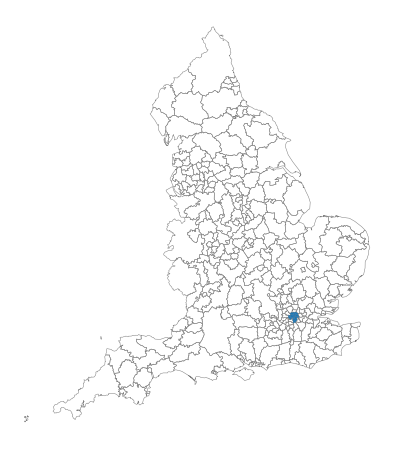

In [69]:
fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(111, projection=ccrs.Mercator())

LAD.plot(ax=ax, edgecolor=(0.5, 0.5, 0.5,1),facecolor='none', linewidth=0.5)
ax.axis('off') 
site_density_most.plot(ax=ax)

# Find the top 10 LADs have highest vaccination site density/number (London exclude)

In [14]:
# Get the London boundary map for more conplex map plot 
# Read some London Boundary data for map show
# An intricate map of London's borders
borough = gpd.read_file('https://github.com/LingruFeng/0006_DSSS_assessment/blob/main/London_Boroughs.gpkg?raw=true')
borough = borough.to_crs('epsg:27700')

In [21]:
test = pd.merge(left = LAD, right=borough[['gss_code','objectid']],how = 'left', left_on='LAD20CD', right_on='gss_code')
LAD_except_London =test[pd.isnull(test).any(axis=1)]
print(LAD_except_London.shape)

(281, 14)


In [31]:
site_number_most=LAD_except_London.sort_values(axis = 0,ascending = False,by = 'NUMPOINTS').head(10).reset_index()
site_number_most.drop(columns='index', axis=1,inplace=True)
site_number_most[['LAD20NM','NUMPOINTS','site_density']]

,LAD20NM,NUMPOINTS,site_density
0,Birmingham,18,0.066908
1,Leeds,15,0.027244
2,Buckinghamshire,13,0.008267
3,Dartford,11,0.151104
4,"Bristol, City of",11,0.100612
5,Manchester,10,0.089369
6,Cheshire West and Chester,9,0.009816
7,Cornwall,9,0.002517
8,Kirklees,8,0.019738
9,Watford,8,0.352207


In [72]:
site_density_most=LAD_except_London.sort_values(axis = 0,ascending = False,by = 'site_density').head(10).reset_index()
site_density_most.drop(columns='index', axis=1,inplace=True)
site_density_most[['LAD20NM','NUMPOINTS','site_density']]

,LAD20NM,NUMPOINTS,site_density
0,Watford,8,0.352207
1,Epsom and Ewell,6,0.172318
2,Portsmouth,6,0.153146
3,Dartford,11,0.151104
4,Oxford,6,0.133020
5,Cambridge,5,0.124356
6,Southend-on-Sea,5,0.113109
7,Stevenage,3,0.111839
8,"Bristol, City of",11,0.100612
9,Harlow,3,0.100504


<GeoAxesSubplot:>

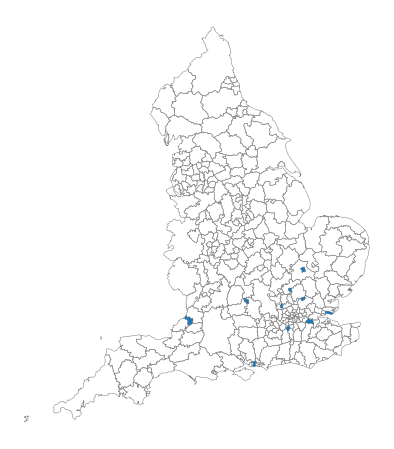

In [71]:
fig = plt.figure(1, figsize=(8, 8))
ax = fig.add_subplot(111, projection=ccrs.Mercator())

LAD.plot(ax=ax, edgecolor=(0.5, 0.5, 0.5,1),facecolor='none', linewidth=0.5)
ax.axis('off') 
site_density_most.plot(ax=ax)

# Find out the LAD that have no vaccination site

There are 24 LADs have no site

In [12]:
no_site_LAD = LAD[LAD['site_density']==0]
no_site_LAD.shape

(24, 12)

<AxesSubplot:>

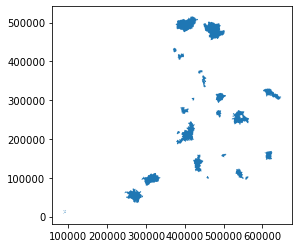

In [33]:
no_site_LAD.plot()

In [13]:
no_site_LAD[['LAD20NM']]

,LAD20NM
16,Rutland
49,Isles of Scilly
61,South Cambridgeshire
70,Chesterfield
76,East Devon
80,South Hams
84,Eastbourne
86,Lewes
102,Cotswold
104,Gloucester


In [51]:
LAD_except_London['site_density100']=LAD_except_London['site_density']*100

/opt/conda/envs/sds2020/lib/python3.7/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [65]:
def LAD_plot(column):
    fig = plt.figure(1, figsize=(13, 13))
    ax = fig.add_subplot(111, projection=ccrs.Mercator())
    
    LAD_except_London.plot(ax=ax,column=column, edgecolor='None',
              scheme='NaturalBreaks',k=7,legend=True)
    ax.axis('off') 
    #ax.set_title('England Household percentage with at least one car by MSOA', fontdict={'fontsize':'20', 'fontweight':'3'})
    
    ax.get_legend().set_title(u'Site number per 100km\u00B2')
    ax.get_legend().get_title().set_fontsize('15')
    
    #north arrow
    ax.text(x=180000, y=590000, s='N', fontsize=30)
    ax.arrow(190000, 530000, 0, 60000, length_includes_head=True,
          head_width=20000, head_length=80000, overhang=.1, facecolor='k')
    #scale bar
    text_kwargs = dict(family='serif', size='xx-large')
    scale_bar(ax, (0.8, 0.7), 100,text_kwargs = text_kwargs)

    q = mc.NaturalBreaks(LAD_except_London[column], k=7)
    legendgram(fig, ax, 
                LAD_except_London[column], q.bins, bins=20,
                pal=palmpl.Viridis_7,
                legend_size=(0.5, 0.12), 
                loc='lower right',
                #clip=(0,100),
                frameon=False)

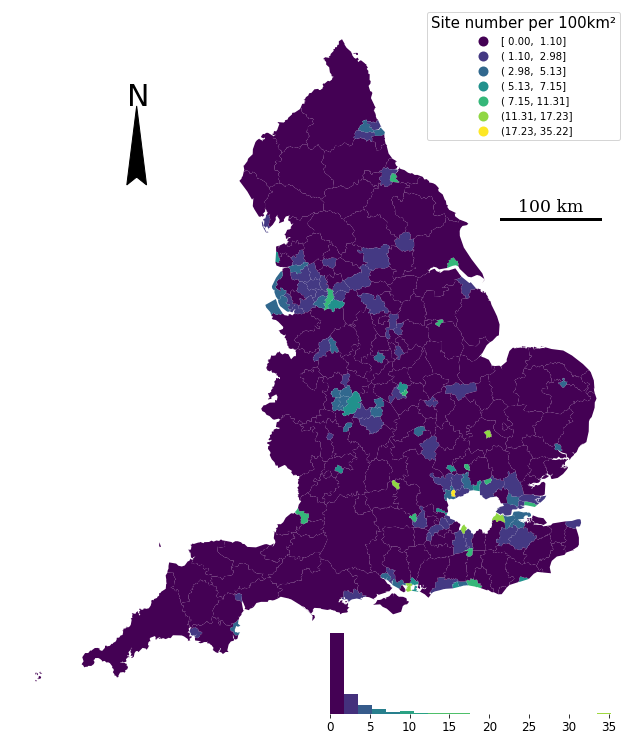

In [66]:
LAD_plot('site_density100')